In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

# Setup paths to folders
data_path = Path("/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/training_data")
pre_image_path = data_path / "images_pre"
post_image_path = data_path / "images_post"
pre_mask_path = data_path / "masks_pre"
damage_mask_path = data_path / "masks_post"

# Dataset

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
from imageio.v2 import imread

class xBD(Dataset):
    def __init__(self, pre_img_dir, post_img_dir, pre_mask_dir, damage_mask_dir, transform=None):
        self.pre_img_dir = pre_image_path
        self.post_img_dir = post_image_path
        self.pre_mask_dir = pre_mask_path
        self.damage_mask_dir = damage_mask_path
        self.transform = transform

        # Get the lists of image and mask file names
        self.pre_img_files = os.listdir(pre_img_dir)
        self.post_img_files = os.listdir(post_img_dir)
        self.pre_mask_files = os.listdir(pre_mask_dir)
        self.damage_mask_files = os.listdir(damage_mask_dir)

        # Sort the file names in ascending order
        self.pre_img_files.sort()
        self.post_img_files.sort()
        self.pre_mask_files.sort()
        self.damage_mask_files.sort()

    def __len__(self):
        return len(self.pre_img_files)

    def __getitem__(self, idx):
        # Read the images and masks into NumPy arrays
        pre_img = imread(os.path.join(self.pre_img_dir, self.pre_img_files[idx]))
        post_img = imread(os.path.join(self.post_img_dir, self.post_img_files[idx]))
        pre_mask = imread(os.path.join(self.pre_mask_dir, self.pre_mask_files[idx]))
        damage_mask = imread(os.path.join(self.damage_mask_dir, self.damage_mask_files[idx]))

        # Corrections
        pre_img = np.nan_to_num(pre_img, 0)
        post_img = np.nan_to_num(post_img, 0)
        pre_mask = pre_mask.astype(float)
        damage_mask = damage_mask.astype(float)
        pre_mask = pre_mask / 255 # 0, 255 -> 0, 1
        damage_mask[damage_mask == 255] = 0 # 1, 2, 3, 4, 255 -> 0, 1, 2, 3, 4
        damage_mask = damage_mask - 1 # 0, 1, 2, 3, 4 -> -1, 0, 1, 2, 3

        # Apply data augmentation if specified
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
            pre_mask = self.transform(pre_mask)
            damage_mask = self.transform(damage_mask)
        
        # Convert numpy arrays to PyTorch tensors
        pre_img = torch.from_numpy(pre_img).float() / 255 # normalize to range [0, 1]
        post_img = torch.from_numpy(post_img).float() / 255 # normalize to range [0, 1]
        pre_mask = torch.from_numpy(pre_mask).long()
        damage_mask = torch.from_numpy(damage_mask).long()

        # Change the shape (HWC -> CHW)
        pre_img = pre_img.permute(2, 0, 1)
        post_img = post_img.permute(2, 0, 1)

        # Calculate post-event building masks
        post_mask = pre_mask * (damage_mask < 3) # post-event building mask
 
        # Output
        return pre_img, post_img, pre_mask, post_mask, damage_mask

In [ ]:
import matplotlib.pyplot as plt

def data_case(x):
  data = xBD(pre_image_path, post_image_path, pre_mask_path, damage_mask_path)
  print(f"Dataset size: {len(data)}")
  pre_imgx, post_imgx, pre_maskx, post_maskx, damage_maskx = data[x]
  print(f"Data's shapes: {pre_imgx.shape}, {post_imgx.shape}, {pre_maskx.shape}, {post_maskx.shape}")
  print(f"Masks' unique values: {torch.unique(pre_maskx)}, {torch.unique(post_maskx)}, {torch.unique(damage_maskx)}")

  pre_imgx_ = np.transpose(pre_imgx, (1, 2, 0))
  post_imgx_ = np.transpose(post_imgx, (1, 2, 0))
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
  axs[0, 0].imshow(pre_imgx_.numpy())
  axs[0, 1].imshow(post_imgx_.numpy())
  axs[1, 0].imshow(pre_maskx.numpy(), cmap='gray')
  axs[1, 1].imshow(post_maskx.numpy(), cmap='gray')
  axs[1, 2].imshow(damage_maskx.numpy(), cmap='jet')

  for row in axs:
      for ax in row:
          ax.axis('off')

  # Save the figure with all the subplots
  plot_save_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/models/dataset_example_" + str(x) + ".png"
  plt.savefig(plot_save_path)

  # Display the figure
  plt.show()

Dataset size: 383
Data's shapes: torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]), torch.Size([1024, 1024])
Masks' unique values: tensor([0, 1]), tensor([0, 1]), tensor([-1,  0,  2,  3])


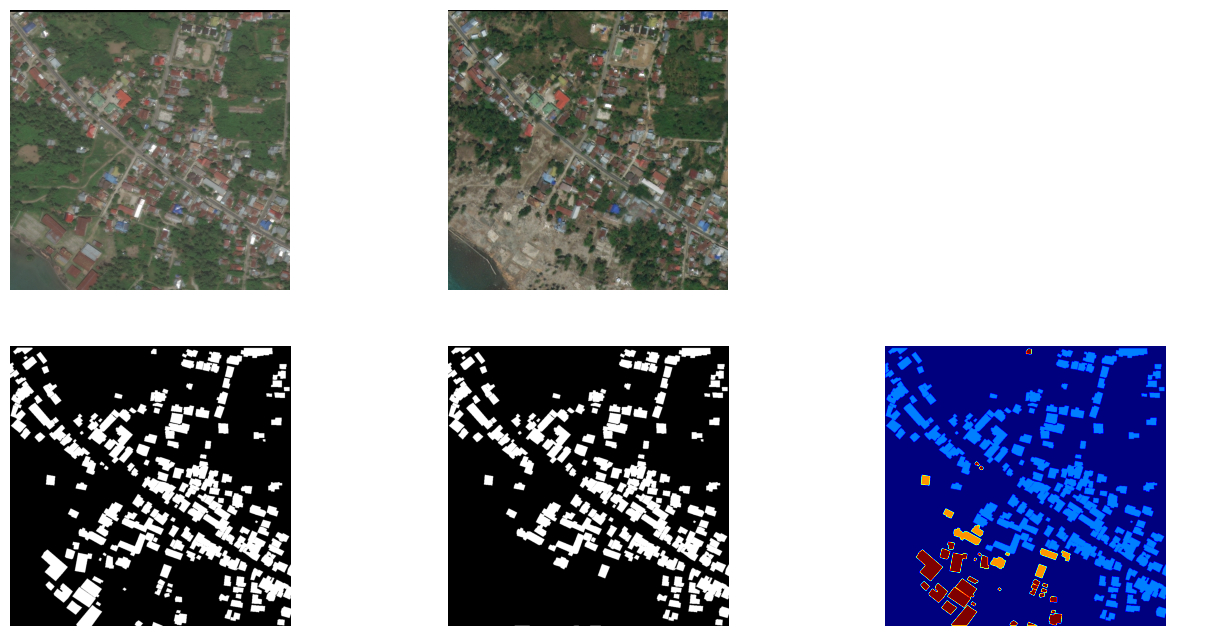

In [ ]:
data_case(272)

Dataset size: 383
Data's shapes: torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]), torch.Size([1024, 1024])
Masks' unique values: tensor([0, 1]), tensor([0, 1]), tensor([-1,  0,  1,  2,  3])


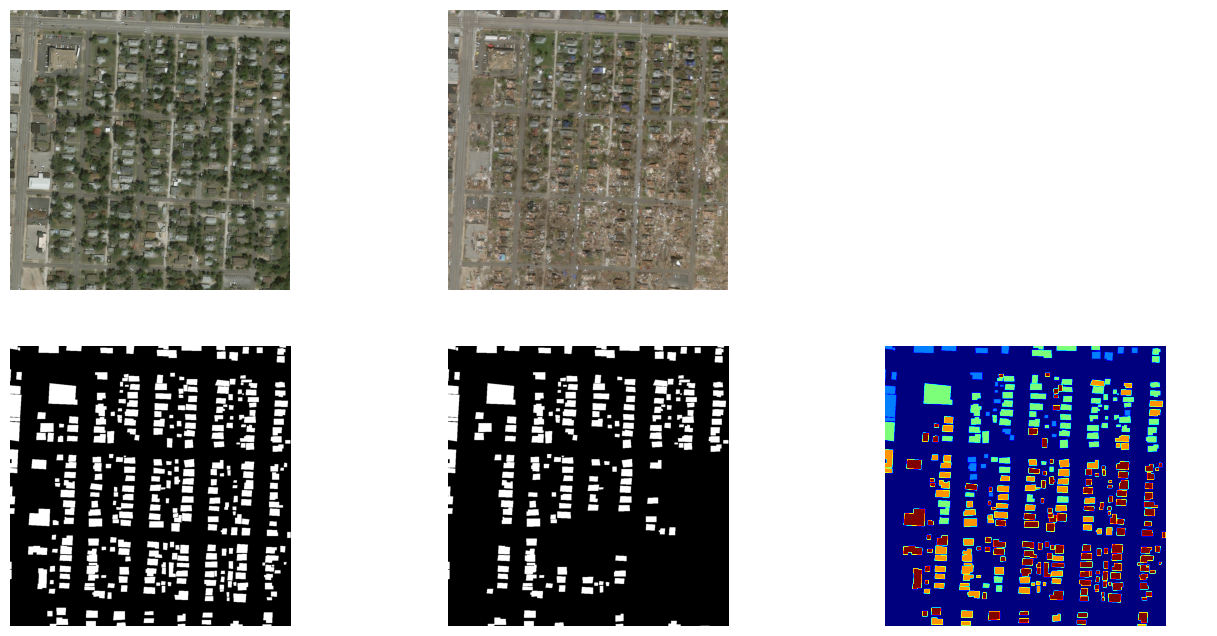

In [ ]:
data_case(120)

Dataset size: 383
Data's shapes: torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]), torch.Size([1024, 1024])
Masks' unique values: tensor([0, 1]), tensor([0, 1]), tensor([-1,  0,  2,  3])


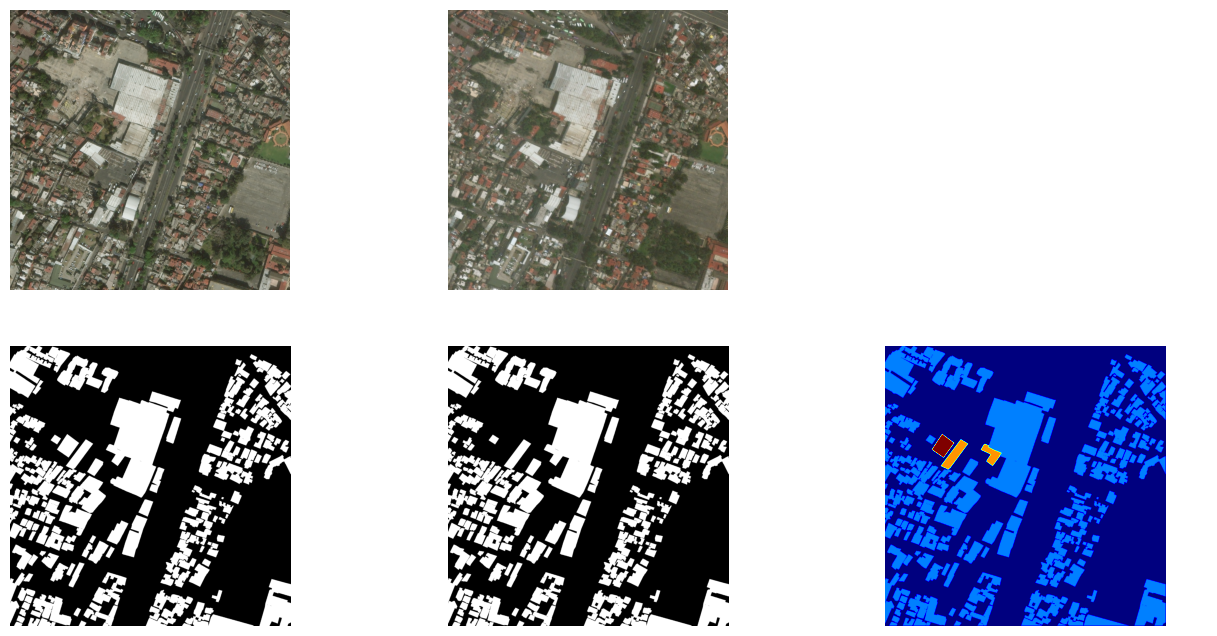

In [ ]:
data_case(190)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=4, features=[16, 32]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of the network
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the network
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        
        # Downward path (Encoder)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottom of the network
        x = self.bottleneck(x)

        # Upward path (Decoder)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=True)
            concat_skip = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
class Dual_UNet(nn.Module):
    def __init__(self, num_class=4, features=[16, 32]):
        super().__init__()

        self.unet = UNet(in_channels=3, out_channels=2, features=features)
        self.damage_head = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, 3, padding=1),
            nn.BatchNorm2d(num_class),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        out1 = self.unet(x1)
        out2 = self.unet(x2)
        out = self.damage_head(torch.cat((out1, out2), dim=1))
        
        return out1, out2, out

# Train

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

# Initialize the dataset
dataset = xBD(pre_image_path, post_image_path, pre_mask_path, damage_mask_path)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define the batch size
batch_size = 4

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and data to the appropriate device
model = Dual_UNet().to(device)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 100

# Create lists for storing losses
train_losses = []
val_losses = []

# Optimize the model
for epoch in range(num_epochs):
    # Training loop
    model.train() # Set the model to training mode
    train_loss = 0.0

    for batch_idx, (pre_imgs, post_imgs, pre_masks, post_masks, damage_masks) in enumerate(train_loader):

        # Move the data to the appropriate device
        pre_imgs = pre_imgs.to(device)
        post_imgs = post_imgs.to(device)
        pre_masks = pre_masks.to(device)
        post_masks = post_masks.to(device)
        damage_masks = damage_masks.to(device)
        
        # Forward pass
        out1, out2, out = model(pre_imgs, post_imgs)

        # Calculate the loss
        loss1 = criterion(out1, pre_masks)
        loss2 = criterion(out2, post_masks)
        damage_loss = criterion(out, damage_masks)

        loss = loss1 + loss2 + damage_loss

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        # Print what's happening
        if (epoch + 1) % 10 == 0 and (batch_idx + 1) % 10 == 0: # Set according to preference
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))

    # Calculate and store the average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval() # Set the model to evaluation mode
    val_loss = 0.0

    val_acc1 = 0.0
    val_acc2 = 0.0
    val_acc = np.zeros((4))

    with torch.no_grad():
        for val_pre_imgs, val_post_imgs, val_pre_masks, val_post_masks, val_damage_masks in val_loader:

            # Move the data to the appropriate device
            val_pre_imgs = val_pre_imgs.to(device)
            val_post_imgs = val_post_imgs.to(device)
            val_pre_masks = val_pre_masks.to(device)
            val_post_masks = val_post_masks.to(device)
            val_damage_masks = val_damage_masks.to(device)

            # Forward pass
            val_out1, val_out2, val_out = model(val_pre_imgs, val_post_imgs)
            
            # Calculate the loss
            val_loss1 = criterion(val_out1, val_pre_masks)
            val_loss2 = criterion(val_out2, val_post_masks)
            val_damage_loss = criterion(val_out, val_damage_masks)
            validation_loss = val_loss1 + val_loss2 + val_damage_loss
        
            # Accumulate the validation loss
            val_loss += validation_loss.item()

            # Calculate the accuracies
            pred_labels1 = torch.argmax(val_out1.softmax(dim=1), dim=1).squeeze().cpu().numpy().flatten()
            truth_labels1 = val_pre_masks.cpu().numpy().flatten()
            pred_labels2 = torch.argmax(val_out2.softmax(dim=1), dim=1).squeeze().cpu().numpy().flatten()
            truth_labels2 = val_post_masks.cpu().numpy().flatten()
            pred_labels_damage = torch.argmax(val_out.softmax(dim=1), dim=1).squeeze().cpu().numpy().flatten()
            truth_labels_damage = val_damage_masks.cpu().numpy().flatten()

            pre_f1 = f1_score(truth_labels1, pred_labels1)
            post_f1 = f1_score(truth_labels2, pred_labels2)
            damage_f1 = f1_score(truth_labels_damage[truth_labels_damage != -1], pred_labels_damage[truth_labels_damage != -1], labels = [0, 1, 2, 3], average=None, zero_division = 0)

            # Accumulate the accuracies
            val_acc1 += pre_f1
            val_acc2 += post_f1
            val_acc += damage_f1

    # Calculate and store the average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate the average accuracies for the epoch
    avg_val_acc1 = val_acc1 / len(val_loader)
    avg_val_acc2 = val_acc2 / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # Print the average training and validation loss
    if (epoch + 1) % 10 == 0: # Set according to preference
      print('Epoch [{}/{}], Avg. Training Loss: {:.4f}, Avg. Validation Loss: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
      print('\t\tAvg. Validation Pre-Event Building Segmentation Performance: {:.4f} \n\t\tAvg. Validation Post-Event Building Segmentation Performance: {:.4f}'
            .format(avg_val_acc1, avg_val_acc2))
      print('\t\tAvg. Validation Damage Performance:')
      for i, acc in enumerate(avg_val_acc):
        print('\t\t\t{}: {:.4f}'.format(i, acc))
      print('\t\tMean: {:.4f}'.format(np.mean(avg_val_acc)))

# Training complete

Epoch [10/100], Step [10/77], Loss: 2.1679
Epoch [10/100], Step [20/77], Loss: 0.8282
Epoch [10/100], Step [30/77], Loss: 0.7473
Epoch [10/100], Step [40/77], Loss: 1.1984
Epoch [10/100], Step [50/77], Loss: 0.7850
Epoch [10/100], Step [60/77], Loss: 1.0522
Epoch [10/100], Step [70/77], Loss: 0.6943
Epoch [10/100], Avg. Training Loss: 1.1570, Avg. Validation Loss: 0.9668
		Avg. Validation Pre-Event Building Segmentation Performance: 0.6701 
		Avg. Validation Post-Event Building Segmentation Performance: 0.6133
		Avg. Validation Damage Performance:
			0: 0.9319
			1: 0.0751
			2: 0.0005
			3: 0.3790
		Mean: 0.3466
Epoch [20/100], Step [10/77], Loss: 1.7590
Epoch [20/100], Step [20/77], Loss: 0.6527
Epoch [20/100], Step [30/77], Loss: 0.6510
Epoch [20/100], Step [40/77], Loss: 1.0595
Epoch [20/100], Step [50/77], Loss: 0.6506
Epoch [20/100], Step [60/77], Loss: 1.0072
Epoch [20/100], Step [70/77], Loss: 0.5873
Epoch [20/100], Avg. Training Loss: 1.0189, Avg. Validation Loss: 0.8885
		Avg

# Extra

In [ ]:
from pathlib import Path

# Setup
data_path = Path("/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX")
model_path = data_path / "models"

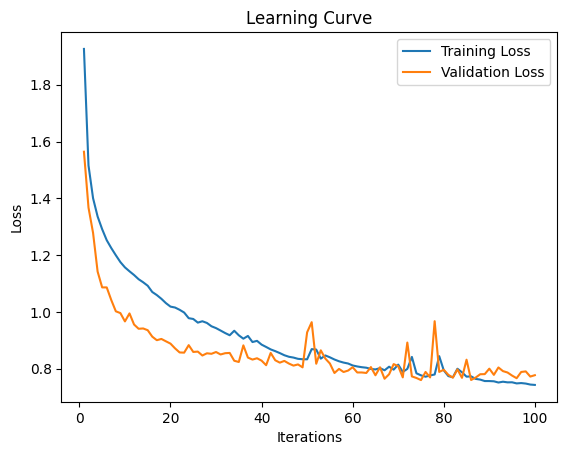

In [ ]:
import os
import matplotlib.pyplot as plt

# Plot the learning curve
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()

# Save the plot as an image file
plot_name = "learning_curve2.png"
plot_save_path = model_path / plot_name
plt.savefig(plot_save_path)

# Save and load model for inference

In [ ]:
model_name = "model2.pth"
model_save_path = model_path / model_name

In [ ]:
# Save the model parameters
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), f=model_save_path)

Saving model to: /content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/models/model2.pth


In [ ]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_saved = Dual_UNet().to(device)
model_saved.load_state_dict(torch.load(model_save_path, map_location=device))
model_saved.eval()

Dual_UNet(
  (unet): UNet(
    (ups): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (downs): ModuleList(
      (0): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# Test predictions

In [ ]:
import matplotlib.pyplot as plt

def test_case(x):
  dataset = xBD(pre_image_path, post_image_path, pre_mask_path, damage_mask_path)
  pre_imgx, post_imgx, pre_maskx, post_maskx, damage_maskx = dataset[x]

  pre_imgx_ = pre_imgx.unsqueeze(0).to(device)
  post_imgx_ = post_imgx.unsqueeze(0).to(device)

  out1_x, out2_x, out_x = model_saved(pre_imgx_, post_imgx_)

  print(f"Output's unique values: {torch.unique(torch.argmax(out1_x.softmax(dim=1), dim=1))}, {torch.unique(torch.argmax(out2_x.softmax(dim=1), dim=1))}, {torch.unique(torch.argmax(out_x.softmax(dim=1), dim=1))}")

  pre_buildings_pred = torch.argmax(out1_x.softmax(dim=1), dim=1).squeeze().cpu().numpy()
  post_buildings_pred = torch.argmax(out2_x.softmax(dim=1), dim=1).squeeze().cpu().numpy()
  damage_pred = torch.argmax(out_x.softmax(dim=1), dim=1).squeeze().cpu().numpy()

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))
  axs[0].imshow(pre_buildings_pred, cmap='gray')
  axs[1].imshow(post_buildings_pred, cmap='gray')
  axs[2].imshow(damage_pred, cmap='jet')

  damage_pred_masked = damage_pred
  damage_pred_masked[pre_buildings_pred == 0] = -1
  axs[3].imshow(damage_pred_masked, cmap='jet')

  for ax in axs:
      ax.axis('off')

  # Save the figure with all the subplots
  plot_name = "training_example_results" + str(x) + ".png"
  plot_save_path = model_path / plot_name
  plt.savefig(plot_save_path)

  # Display the figure
  plt.show()

Output's unique values: tensor([0, 1], device='cuda:0'), tensor([0, 1], device='cuda:0'), tensor([0, 1, 2, 3], device='cuda:0')


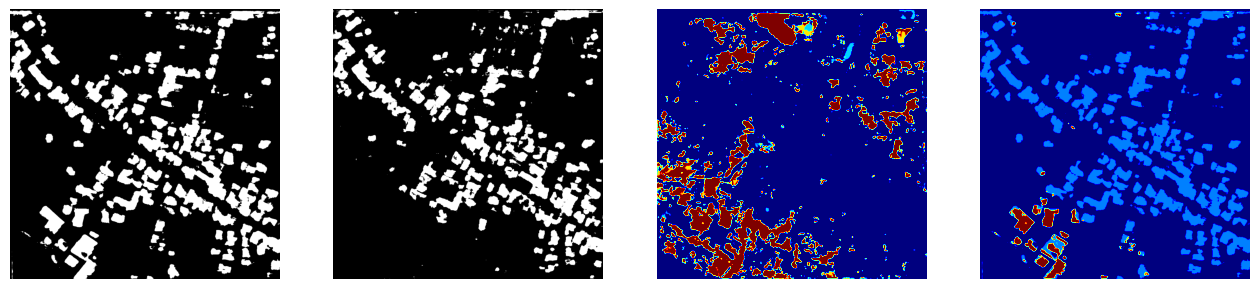

In [ ]:
test_case(272)

Output's unique values: tensor([0, 1], device='cuda:0'), tensor([0, 1], device='cuda:0'), tensor([0, 1, 2, 3], device='cuda:0')


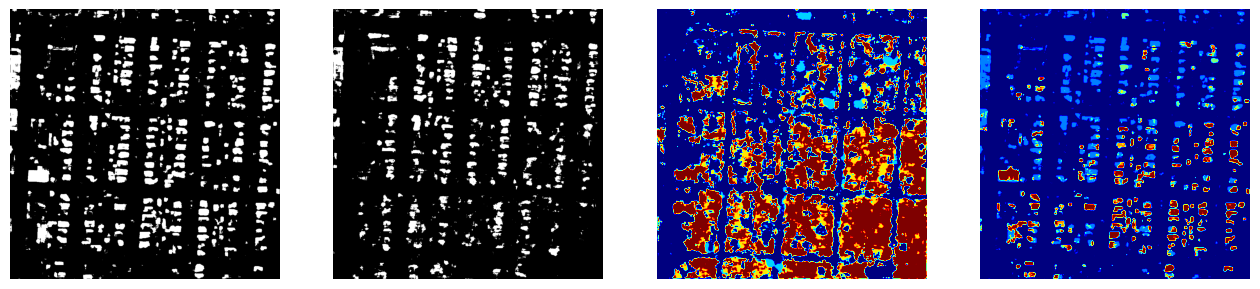

In [ ]:
test_case(120)

Output's unique values: tensor([0, 1], device='cuda:0'), tensor([0, 1], device='cuda:0'), tensor([0, 1, 2, 3], device='cuda:0')


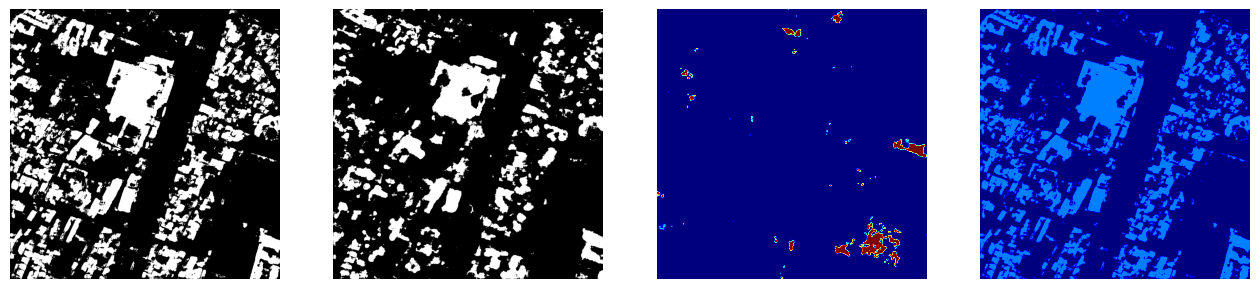

In [ ]:
test_case(190)

# Turkey predictions

In [ ]:
import torch
import torchvision.transforms.functional as F
from PIL import Image

def tensors_to_images(tensors, output_image_path, images_per_row):
    # Calculate the number of rows and columns
    num_images = len(tensors)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    num_columns = min(num_images, images_per_row)

    # Get the dimensions of the tensors
    width, height = tensors[0].shape[2], tensors[0].shape[1]

    # Create a new blank image to hold the combined pieces
    combined_image = Image.new("L", (width * num_columns, height * num_rows))

    # Iterate over the tensors and paste each tensor onto the combined image
    for i, tensor in enumerate(tensors):
        tensor = tensor.to(torch.uint8)
        image = F.to_pil_image(tensor)
        x = i % images_per_row
        y = i // images_per_row
        left = x * width
        upper = y * height
        combined_image.paste(image, (left, upper))

    # Save the combined image as PNG
    combined_image.save(output_image_path, format="PNG")

In [ ]:
import torch
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np

color_mapping = {
    0: (1, 128, 0),
    1: (255, 254, 0),
    2: (255, 165, 0),
    3: (255, 0, 0)
}

def tensors_to_images2(tensors, output_image_path, images_per_row):
    # Calculate the number of rows and columns
    num_images = len(tensors)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    num_columns = min(num_images, images_per_row)

    # Get the dimensions of the tensors
    width, height = tensors[0].shape[2], tensors[0].shape[1]

    # Create a new blank image to hold the combined pieces
    combined_image = Image.new("RGB", (width * num_columns, height * num_rows))

    # Iterate over the tensors and paste each tensor onto the combined image
    for i, tensor in enumerate(tensors):
        color_np = np.zeros((height, width, 3), dtype=np.uint8)
        for intensity, color in color_mapping.items():
          color_np[tensor.squeeze().cpu().numpy() == intensity] = color

        image = F.to_pil_image(color_np)
        x = i % images_per_row
        y = i // images_per_row
        left = x * width
        upper = y * height
        combined_image.paste(image, (left, upper))

    # Save the combined image as PNG
    combined_image.save(output_image_path, format="PNG")

In [ ]:
import os
import numpy as np
import torch
from imageio.v2 import imread
import matplotlib.pyplot as plt

# Setup
pre_img_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/output/pre_images/Kpre"
post_img_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/output/post_images/Kpost"
pre_img_files = []
for pre_filename in os.listdir(pre_img_path):
  pre_img_files.append(os.path.join(pre_img_path, pre_filename))
post_img_files = []
for post_filename in os.listdir(post_img_path):
  post_img_files.append(os.path.join(post_img_path, post_filename))

def read_and_preprocess(path):
  image = imread(path)
  image = np.nan_to_num(image, 0)
  image = torch.from_numpy(image).float() / 255
  image = image.permute(2, 0, 1)
  return image

pre_buildings_list = []
post_buildings_list = []
damage_list = []

# Make predictions
for i in range(len(pre_img_files)):
    pre_img = read_and_preprocess(pre_img_files[i]).unsqueeze(0).to(device)
    post_img = read_and_preprocess(post_img_files[i]).unsqueeze(0).to(device)

    out1, out2, out = model_saved(pre_img, post_img)

    pre_buildings_pred = torch.argmax(out1.softmax(dim=1), dim=1)
    post_buildings_pred = torch.argmax(out2.softmax(dim=1), dim=1)
    damage_pred = torch.argmax(out.softmax(dim=1), dim=1)

    pre_buildings_list.append(pre_buildings_pred * 255)
    post_buildings_list.append(post_buildings_pred * 255)
    damage_list.append(damage_pred)

In [ ]:
images_per_row = 7

pre_buildings_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Kprebuildings2.png"
post_buildings_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Kpostbuildings2.png"
damage_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Kdamage2.png"

tensors_to_images(pre_buildings_list, pre_buildings_path, images_per_row)
tensors_to_images(post_buildings_list, post_buildings_path, images_per_row)
tensors_to_images2(damage_list, damage_path, images_per_row)

In [ ]:
import os
import numpy as np
import torch
from imageio.v2 import imread
import matplotlib.pyplot as plt

# Setup
pre_img_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/output/pre_images/Apre"
post_img_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/output/post_images/Apost"
pre_img_files = []
for pre_filename in os.listdir(pre_img_path):
  pre_img_files.append(os.path.join(pre_img_path, pre_filename))
post_img_files = []
for post_filename in os.listdir(post_img_path):
  post_img_files.append(os.path.join(post_img_path, post_filename))

def read_and_preprocess(path):
  image = imread(path)
  image = np.nan_to_num(image, 0)
  image = torch.from_numpy(image).float() / 255
  image = image.permute(2, 0, 1)
  return image

pre_buildings_list = []
post_buildings_list = []
damage_list = []

# Make predictions
for i in range(len(pre_img_files)):
    pre_img = read_and_preprocess(pre_img_files[i]).unsqueeze(0).to(device)
    post_img = read_and_preprocess(post_img_files[i]).unsqueeze(0).to(device)

    out1, out2, out = model_saved(pre_img, post_img)

    pre_buildings_pred = torch.argmax(out1.softmax(dim=1), dim=1)
    post_buildings_pred = torch.argmax(out2.softmax(dim=1), dim=1)
    damage_pred = torch.argmax(out.softmax(dim=1), dim=1)

    pre_buildings_list.append(pre_buildings_pred * 255)
    post_buildings_list.append(post_buildings_pred * 255)
    damage_list.append(damage_pred)

In [ ]:
images_per_row = 7

pre_buildings_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Aprebuildings2.png"
post_buildings_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Apostbuildings2.png"
damage_path = "/content/drive/MyDrive/Samhällsbyggnadsprogrammet/KEX/Turkey/predictions/Adamage2.png"

tensors_to_images(pre_buildings_list, pre_buildings_path, images_per_row)
tensors_to_images(post_buildings_list, post_buildings_path, images_per_row)
tensors_to_images2(damage_list, damage_path, images_per_row)